# **Basic Trends in Open Access Academic Articles**
## Exploring Publication Metrics with *OpenAlex* 
### A step-by-step walkthrough

This notebook includes the following basic analyses:
- Proportions of articles in open access 
- Proportions of articles by open access status 

See other Notebooks in the repository for other analyses
- Analogous to this notebook with OpenAire: openaire_oa_analyses.ipynb
- First Analyses: openalex_first_analyses.ipynb
- with OpenAire: openaire_first_analyses.ipynb



### Analysis 1: Assess Proportions of Open Access Articles
> Note: If you want to perform the exact same analysis, then you only have to modify Step 6 to choose the institution you want or adjust/add other parameters.

##### Step 1.1: Imports
To include all necessary imports for setup, you need to install the `requirements.txt` file first. Ensure you're in the right repository and then paste the following command into your terminal: `$ pip install -r requirements.txt`

We need these libraries for:
- `requests`: To make API calls
- `pandas`: To process and manipulate data
- `datetime`: To calculate year ranges
- `matplotlib`: For visualizing data
- `numpy`: To work with arrays

In [20]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from open_colors import colors

##### Step 1.2: Response Validation
This function checks the API response's status code. If it is not 200, it raises an error with details about the failure.

In [2]:
def validate_response(response):
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data. Status code for {response.url}: {response.status_code}")

##### Step 1.3: Build Parameters
This function constructs the query parameters:
- `start_year` and `current_year`: Define the publication year range.
- `institution_id`: Specifies the institution to filter by.
- `publication_type`: Specifies what kind of publication.
- `use_lineage`: Gives the option to include child institutions.

In [3]:
def build_params(start_year, current_year, institution_id=None, publication_type="article", use_lineage=False):
    if use_lineage:
        filter_key = "authorships.institutions.lineage.id" # includes child institutions
    else:
        filter_key = "institutions.id"
    
    return {
        "filter": f"{filter_key}:{institution_id},publication_year:{start_year}-{current_year},type:{publication_type}",
        "group_by": "is_oa"
    }

##### Step 1.4: Count Open Access Publications from an Institution

In [4]:
def analyze_oa(base_url, start_year, current_year, institution_id, use_lineage=False):
    # Build parameters for the request
    params = build_params(start_year, current_year, institution_id, use_lineage=use_lineage)
    response = requests.get(base_url, params=params)
    print(f"Request URL: {response.url}")

    data = validate_response(response)

    # Extract grouped results
    grouped_results = data.get("group_by", [])
    if not grouped_results:
        raise Exception("No data returned. Please check your parameters or try again later.")

    # Build counts for OA and non OA
    counts = {result["key"]: result["count"] for result in grouped_results} 
    oa_count = counts.get('1', 0)
    non_oa_count = counts.get('0', 0)
    total_articles = oa_count + non_oa_count

    return {
        "open_access_count": oa_count,
        "closed_access_count": non_oa_count,
        "oa_percentage": (oa_count / total_articles) * 100 if total_articles else 0,
        "non_oa_percentage": (non_oa_count / total_articles) * 100 if total_articles else 0
    }

##### Step 1.5: Plot Donut Chart
> Note: Essentially you can choose any kind of visualization you think suits your analysis. Here, we provide possible examples, which you can custom as well:

In [ ]:
def plot_oa_donut(oa_percentage, non_oa_percentage):
    labels = ["Open Access", "Closed Access"]
    sizes = [oa_percentage, non_oa_percentage]
    plot_colors = [colors["teal"][8], colors["red"][7]]

    fig, ax = plt.subplots(figsize=(6, 6))

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=plot_colors,
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={"fontsize": 14}
    )

    # Draw center circle to make it a donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Formatting title
    ax.set_title(
        "Proportions of Open Access vs Closed Access Articles at ETH",
        fontsize=16,
        fontweight='bold'
    )

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

##### Step 1.6: Define Parameters
Here, we specify:
- `institution_id`: The ID of the institution to analyze.
    - search on OpenAlex for your institution (https://openalex.org/institutions) and copy its ID from the URL.
    - IDs for institutions begin with “I” and are followed by 9-digits
    - E.g. in the URL "https://openalex.org/institutions/i35440088" we find i35440088 as ID for ETH Zürich.
- `start_year` and `current_year`: The range of publication years to analyze.
    - we use datetime, but you can just type in the years you want

In [6]:
institution_id = "I35440088" # Example: ID of ETH Züriich
base_url = "https://api.openalex.org/works"
end_year = datetime.now().year
start_year = end_year - 9 #range of 10 years

##### Step 1.6: Fetch OA Article Data

In [7]:
oa_data = analyze_oa(base_url, start_year, end_year, institution_id, use_lineage=False)
print(f"Open Access Articles: {oa_data['open_access_count']} ({oa_data['oa_percentage']:.2f}%)")
print(f"Closed Access Articles: {oa_data['closed_access_count']} ({oa_data['non_oa_percentage']:.2f}%)")

Request URL: https://api.openalex.org/works?filter=institutions.id%3AI35440088%2Cpublication_year%3A2016-2025%2Ctype%3Aarticle&group_by=is_oa
Open Access Articles: 48362 (70.44%)
Closed Access Articles: 20299 (29.56%)


##### Step 1.7 Display Plot

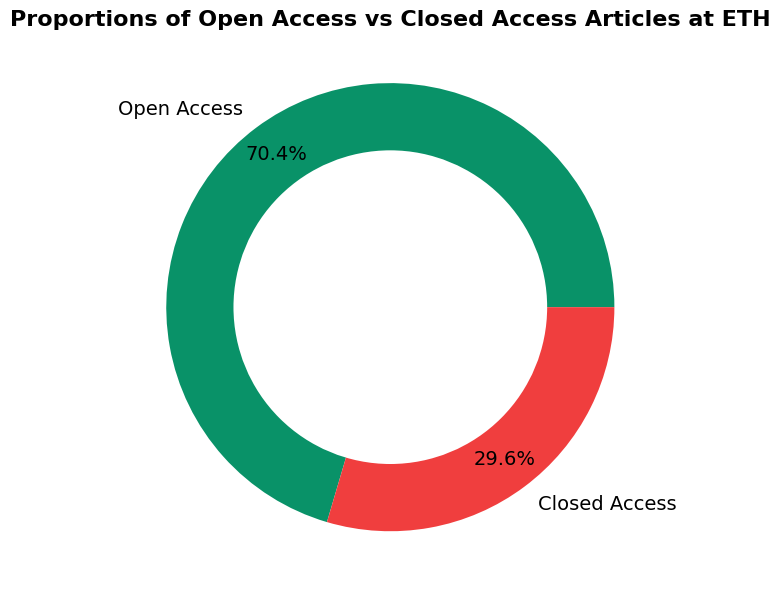

In [33]:
# Visualize open access proportions
plot_oa_donut(oa_data["oa_percentage"], oa_data["non_oa_percentage"])

### Analysis 2: Assess Article Proportions by Open Access Status
OpenAlex provide the following type of status: *diamond*, *gold*, *green*, *hybrid*, *bronze* and *closed*.
- Diamond: Publications are freely available to everyone, with no costs for authors or readers.
- Gold: Published in a fully open-access journal.
- Green: Available in an open repository.
- Hybrid: Published in a subscription journal but made open through APCs.
- Bronze: Freely available but without an explicit open license.
- Closed: Publications are restricted and only available through subscription or paywall, with no free access to the public.

>For further detail check out: https://help.openalex.org/hc/en-us/articles/24347035046295-Open-Access-OA


##### Step 2.1: Build Parameters for Query

In [34]:
def build_params(start_year, end_year, institution_id, oa_status):
    return {
        "filter": f"authorships.institutions.lineage:{institution_id},"
                  f"publication_year:{start_year}-{end_year},"
                  f"type:article,"
                  f"open_access.oa_status:{oa_status}",
        "sort": "cited_by_count:desc",
        "per_page": 10  # Adjust per_page as needed
    }

##### Step 2.2: Fetch and Validate Data

In [35]:
def fetch_data(base_url, params):
    response = requests.get(base_url, params=params)
    return validate_response(response)

##### Step 2.3: Fetch Data for each year and OA status

In [36]:
def fetch_oa_status_by_year(base_url, start_year, end_year, institution_id):
    # Define the OA statuses to fetch
    oa_statuses = ["closed", "green", "gold", "hybrid", "bronze", "diamond"]
    # Initialize an empty list to store the results
    results = []

    # Iterate over the years and fetch the data for each OA status
    for year in range(start_year, end_year + 1):
        yearly_data = {"Year": year}

        for status in oa_statuses:
            params = {
                "filter": f"authorships.institutions.lineage:{institution_id},publication_year:{year},type:article,open_access.oa_status:{status}",
                "sort": "cited_by_count:desc",
                "per_page": 1  # We only need the count
            }
        
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                data = response.json()
                yearly_data[status] = data.get("meta", {}).get("count", 0)
            else:
                yearly_data[status] = 0  

        results.append(yearly_data)

    return pd.DataFrame(results)

##### Step 2.4: Fetch total OA status proportions

In [37]:
def analyze_oa_status(base_url, start_year, end_year, institution_id, use_lineage=True):
    oa_statuses = ["closed", "green", "gold", "hybrid", "bronze", "diamond"]
    results = {}

    for status in oa_statuses:
        params = build_params(None, institution_id, status, use_lineage)
        data = fetch_data(base_url, params)
        results[status] = data.get("meta", {}).get("count", 0)

    total_articles = sum(results.values())
    proportions = {status: (count / total_articles) * 100 if total_articles else 0 for status, count in results.items()}

    return {
        "counts": results,
        "proportions": proportions,
        "total_articles": total_articles
    }

##### Step 2.5: Plot Bar Charts
Simple Visualization: *Bar Chart*

Visualize the counts of open access status within the given year range.

In [ ]:
def plot_total_oa_status(df, title):
    total_counts = df.drop(columns=["Year"]).sum()
    total_sum = total_counts.sum()

    plot_colors = [colors["gray"][8], colors["teal"][8], colors["yellow"][7], colors["blue"][8], colors["orange"][8], colors["pink"][5]]

    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(total_counts.index, total_counts.values, color=plot_colors)

    # Add percentages on top of bars
    for bar in bars:
        height = bar.get_height()
        percentage = f"{(height / total_sum) * 100:.1f}%"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 200,
            percentage,
            ha="center",
            fontsize=12,
            fontweight="bold"
        )
    # Axis formatting
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Open Access Status", fontsize=12)
    ax.set_ylabel("Number of Publications", fontsize=12)
    ax.spines[['top', 'right']].set_visible(False)
    
    plt.tight_layout()
    plt.show()

More Detailed Visualization: **Stacked Bar Chart**


Inspired by: https://oamonitor.ch/de/diagramme-und-daten/journal-monitor/

In [ ]:
def plot_oa_status_stacked(df, title):
    categories = ["closed", "green", "gold", "hybrid", "bronze", "diamond"]
    plot_colors = [colors["gray"][8], colors["teal"][8], colors["yellow"][7], colors["blue"][8], colors["orange"][8], colors["pink"][5]]

    years = df["Year"]
    values = df[categories]

    fig, ax = plt.subplots(figsize=(14, 7))
    bottom = np.zeros(len(df))  # Initialize bottom of stack

    # Loop through categories and stack bars
    for i, category in enumerate(categories):
        ax.bar(
            years,
            values[category],
            label=category.capitalize(),
            color=plot_colors[i],
            bottom=bottom
        )
        bottom += values[category]

    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Number of Publications", fontsize=12)
    ax.set_xticks(years)
    ax.tick_params(axis='x')
    ax.legend(
        title="Open Access Status",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.17),
        ncol=len(categories)
    )

    # Move legend below plot
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

##### Step 2.6: Define Parameters

In [39]:
institution_id = "I35440088"
base_url = "https://api.openalex.org/works"
end_year = datetime.now().year
start_year = end_year - 9  # 10-year range
use_lineage = False

##### Step 2.7: DataFrame

In [40]:
df = fetch_oa_status_by_year(base_url, start_year, end_year, institution_id)
df

,Year,closed,green,gold,hybrid,bronze,diamond
0,2016,2830,1417,858,500,995,125
1,2017,2762,1629,1018,531,945,137
2,2018,2661,1760,1080,654,943,168
3,2019,2540,1833,1283,786,809,159
4,2020,2435,1994,1651,1353,694,198
5,2021,2219,1911,1830,2224,639,193
6,2022,1461,1579,1741,2255,454,286
7,2023,1346,998,1868,2675,481,283
8,2024,1689,534,1656,2322,142,288
9,2025,527,64,354,363,16,64


##### Step 2.8: Display Plots
Visualization 1: **Bar Chart** - Plot percentages of each status total

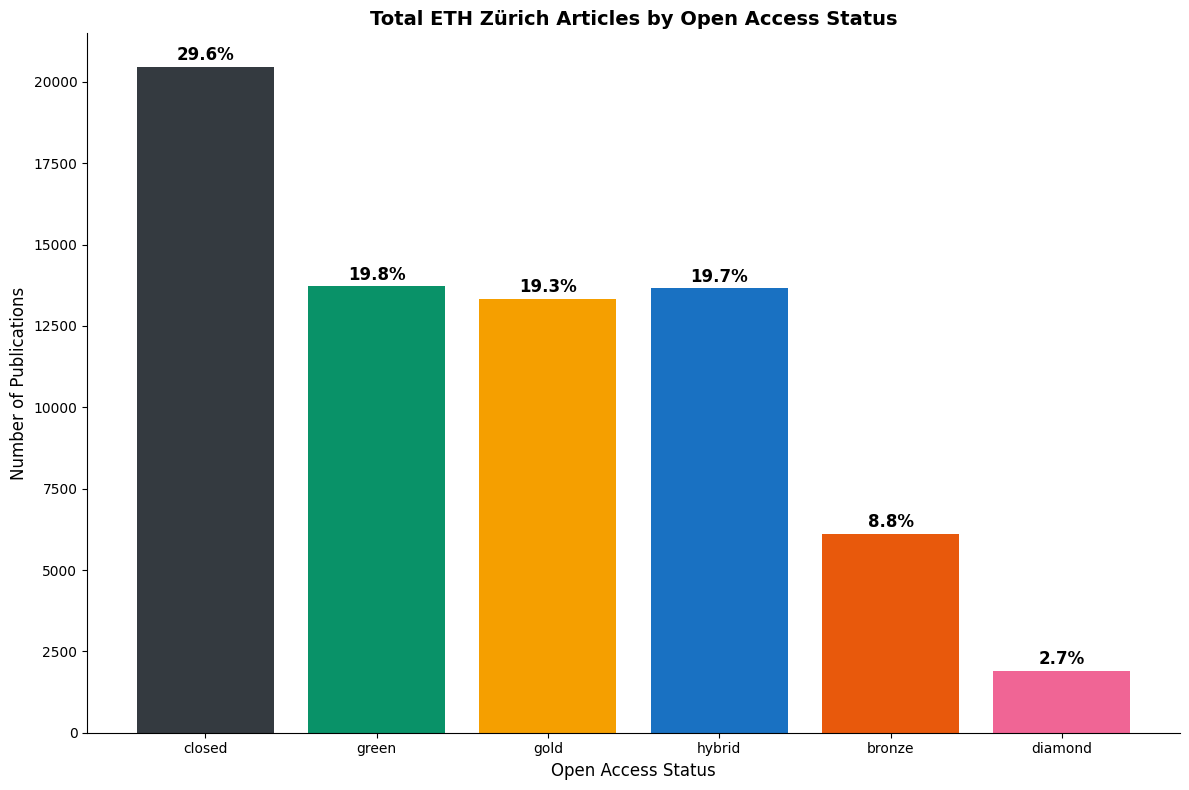

In [60]:
plot_total_oa_status(df, "Total ETH Zürich Articles by Open Access Status")

Visualization 2: **Stacked Bar Chart** - Plot proportions of each status per year

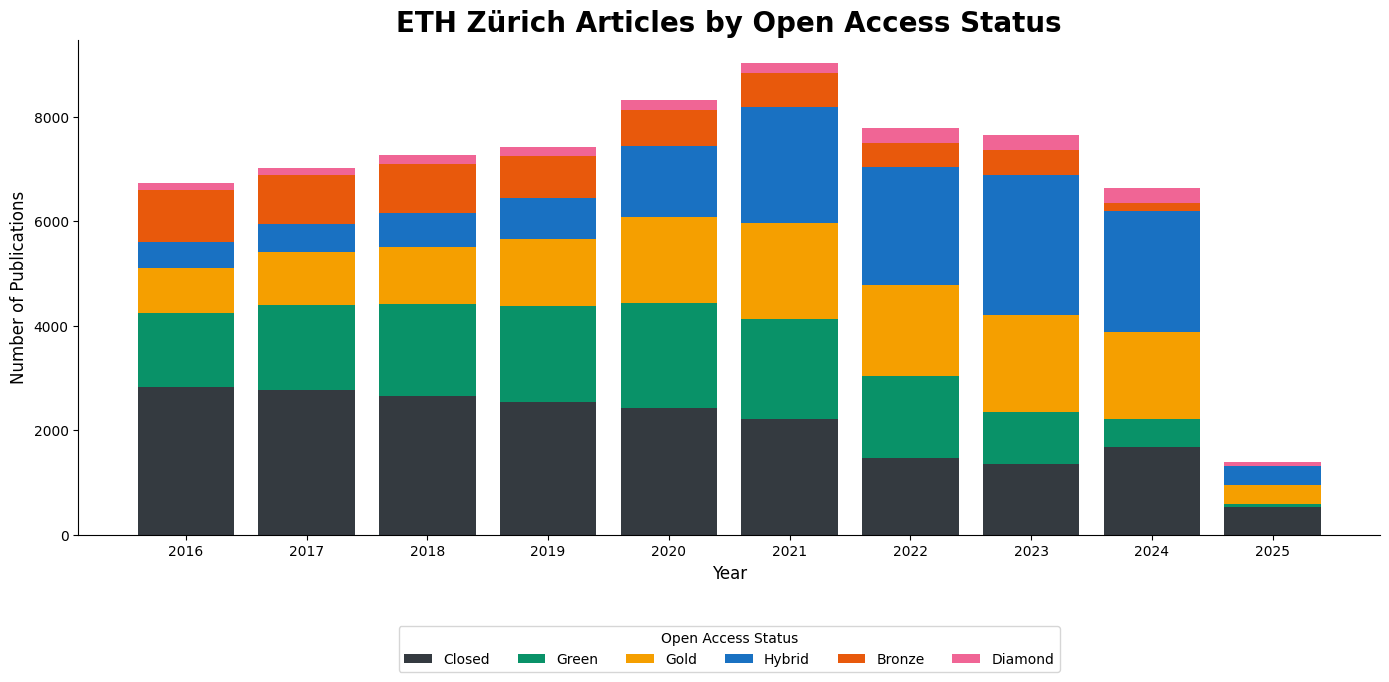

In [62]:
plot_oa_status_stacked(df, "ETH Zürich Articles by Open Access Status")